dataframe with parameters

In [5]:
using DataFrames, CSV
df = CSV.read("hiv_pam.csv", DataFrame);
println("$df")

31×6 DataFrame
 Row │ definition                         symbol    unit                               value        value2         TexSymbols
     │ String                             String15  String                             Float64      Float64        String15
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Естественная смертность 𝑇_1        d1        1/день                                  0.02        0.02       $d_1$
   2 │ Интенсивность  вирусного лизиса …  delta     1/день                                  0.7         0.2095     $\\delta$
   3 │ естественная смертность 𝑇_2, 𝑇_2…  d2        1/день                                  0.005       0.003096   $d_2$
   4 │ Коэффициент потенциальной эффект…  f         [0,1]                                   0.34        0.5068     $f$
   5 │ Относительная эффективность инги…  epsilon2  [0,1]                                   0.0         0.0        $\\

symbolic mathematical model

In [40]:
using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL, OrdinaryDiffEq, Plots
import ModelingToolkit: Interval, infimum, supremum

In [29]:
using ModelingToolkit
import ModelingToolkit: Interval, infimum, supremum

ε_1, ε_2, a_A, a_T = 0.0, 0.0,0.0, 0.008
u = 0.0; rho_1 = 1.0; rho_2 = 1.0; 
@parameters t, d_1, δ, d_2, f, ε_2, a_A, a_T, a_E, γ_E, 
                δ_E2, ε_1, m, K_V, γ_T, c, d_E, δ_E1, p_T, 
                p_E, b_E2, k_1, k_2, λ_T, K_S, N_T, λ_E, K_γ, 
                K_b1, K_b2, K_d, b_E1;

@variables T_1(..), Ts_1(..), T_2(..), Ts_2(..), V_1(..), V_2(..), E_1(..), E_2(..) 
Dt = Differential(t)

eqs=[
        Dt(T_1(t))~-d_1*T_1(t)-(1-u*ε_1)*k_1*V_1(t)*T_1(t)-γ_T*T_1(t)+p_T*(a_T*V_1(t))/(V_1(t)+K_V)*T_2(t)+p_T*a_A*T_2(t),
        Dt(Ts_1(t))~(1-u*ε_1)*k_1*V_1(t)*T_1(t)-δ*Ts_1(t)-m*E_1(t)*Ts_1(t)-γ_T*Ts_1(t)+p_T*(a_T*V_1(t))/(V_1(t)+K_V)*Ts_2(t)+p_T*a_A*Ts_2(t),
        Dt(T_2(t))~λ_T*K_S/(V_1(t)+K_S)+γ_T*T_1(t)-d_2*T_2(t)-(1-f*u*ε_1)*k_2*V_1(t)*T_2(t)-(a_T*V_1(t))/(V_1(t)+K_V)*T_2(t)-a_A*T_2(t),
        Dt(Ts_2(t))~γ_T*Ts_1(t)+(1-f*u*ε_1)*k_2*V_1(t)*T_2(t)-d_2*T_2(t)-(a_T*V_1(t))/(V_1(t)+K_V)*Ts_2(t)-a_A*Ts_2(t),
        Dt(V_1(t))~(1-u*ε_2)*1000.0*N_T*δ*Ts_1(t)-c*V_1(t)-1000.0*((1-u*ε_1)*rho_1*k_1*T_1(t)+(1-f*u*ε_1)*rho_2*k_2*T_2(t))*V_1(t),
        Dt(V_2(t))~u*ε_2*1000.0*N_T*δ*Ts_1(t)-c*V_2(t),
        Dt(E_1(t))~λ_E+b_E1*Ts_1(t)*E_1(t)/(Ts_1(t)+K_b1)-d_E*Ts_1(t)*E_1(t)/(Ts_1(t)+K_d)-δ_E1*E_1(t)-γ_E*(T_1(t)+Ts_1(t))*E_1(t)/(T_1(t)+Ts_1(t)+K_γ)+p_E*a_E*V_1(t)*E_2(t)/(V_1(t)+K_V),
        Dt(E_2(t))~γ_E*(T_1(t)+Ts_1(t))*E_1(t)/(T_1(t)+Ts_1(t)+K_γ)+b_E2*K_b2*E_2(t)/(E_2(t)+K_b2)-δ_E2*E_2(t)-a_E*V_1(t)*E_2(t)/(V_1(t)+K_V)
]

sim = [T_1(0),Ts_1(0),T_2(0),Ts_2(0),V_1(0),V_2(0),E_1(0),E_2(0)];
init_df = [13.13,5.330, 424.4, 2.984, 10., 0., 0.04574, 0.002863]
bcs = [s ~ i for (s,i) in zip(sim,init_df)]
domains = [t ∈ Interval(0.0,100.0)]
dt = 1.0

1.0

In [33]:
sp = [d_1, δ, d_2, f, ε_2, a_A, a_T, a_E, γ_E, 
δ_E2, ε_1, m, K_V, γ_T, c, d_E, δ_E1, p_T, 
p_E, b_E2, k_1, k_2, λ_T, K_S, N_T, λ_E, K_γ, 
K_b1, K_b2, K_d, b_E1];

initial data

#### creat modelling_data

In [1]:
function model_hiv(dX,X,p,t)

    rho1 = 1.; rho2 = 1.;
    ksi1 = p[11]*p[32]; ksi2 = p[5]*p[32];     
    
      dX[1] = -p[1] * X[1] - (1 - ksi1) * p[21] * X[5] * X[1] - p[14] * X[1] + p[18] * (p[7] *(X[5]/(X[5]+p[13]))+p[6]) * X[3];  #dT1
        
      dX[2] = (1. - ksi1) * p[21] * X[5] * X[1] - p[2] * X[2] - p[12] * X[7] * X[2] - p[14] * X[2] + p[18] * (p[7] * (X[5]/(X[5]+p[13])) + p[6]) * X[4]; #dT*_1
        
      dX[3] = p[23] * (p[24]/(X[5]+p[24])) + p[14] * X[1] - p[3] * X[3] - (1. - p[4] * ksi1)  * p[22] * X[5] * X[3] - (p[7] * (X[5]/(X[5]+p[13])) + p[6]) * X[3]; #dT2
      
      dX[4] = p[14] * X[2] + (1 - p[4] * ksi1)  * p[22] * X[5] * X[3] - p[3] * X[4] - (p[7] * (X[5]/(X[5]+p[13])) + p[6]) * X[4]; #dT_2
        
      dX[5] = (1. - ksi2) * 10^3 * p[25] * p[2] * X[2] - p[15] * X[5] - 10^3 * ((1 - ksi1) * rho1 * p[21] * X[1] * X[5]) - 10^3 * ((1. - p[4] * ksi1) * rho2 * p[22] * X[3] * X[5]) ; #dVI
        
      dX[6] = ksi2 * 10^3 * p[25] * p[2] * X[2] - p[15] * X[6]; #dVNI
        
      dX[7] = p[26] + p[31] * (X[2]/(X[2]+p[28])) * X[7] - p[16] * (X[2]/(X[2]+p[30])) * X[7] - p[17] * X[7] - p[9] * ((X[1]+X[2])/(X[1]+X[2]+p[27])) * X[7] + p[19] * p[8] * (X[5]/(X[5]+p[13])) * X[8]; #p[16]1
        
      dX[8] = p[9] * ((X[1]+X[2])/(X[1]+X[2]+p[27])) * X[7] + p[20] * (p[29]/(X[8]+p[29]))* X[8] - p[10] * X[8] - p[8] * (X[5]/(X[5]+p[13])) * X[8];
     
     
end

model_hiv (generic function with 1 method)

In [2]:
using DataFrames, CSV
df = CSV.read("hiv_pam.csv", DataFrame);
df.value2[11] = 0.0
pam = df.value2;


In [3]:
struct Fix
    value 
    index
end

function fix_parameters(dt::DataFrame,find_parameter)# what pust dt::?

    indexes = filter(i->dt[i,1] ∉ find_parameter, range(1,size(dt,1)))
    value_fix = dt[indexes,2]
    fil_set = filter(i->dt[i,1] in find_parameter, range(1,size(dt,1)));
    pam = dt[fil_set,2]
    return (pam,Fix(value_fix,indexes))

end


function CollectVector(q,fix_pam::Fix)
    p = [];
    p = append!(p,q)
    if length(fix_pam.value)!=0 
        for (i,j) in zip(fix_pam.index,fix_pam.value)
        p = insert!(p,i,j) 
        end
    end
    return p
end

using DifferentialEquations
struct ODEs
    model::Function
    ID
    time
    step
  end
  
  
function solve_ODE(ode::ODEs,q; fix_pam=Fix([],[]), method=Tsit5()) #fix_pam = fix, ind = indexes)
    
    pam = CollectVector(q,fix_pam)
    pam = append!(pam,1.0)
    prob = ODEProblem(ode.model,ode.ID,ode.time,pam)
    data =  solve(prob,method,saveat=ode.step);
    return data
end;

In [34]:
ID = [13.13,5.330, 424.4, 2.984, 10., 0., 0.04574, 0.002863]
t_start = 0.0; t_end = 100.0; step = 1.0
tspan = [t_start, t_end]
modelling_data = solve_ODE(ODEs(model_hiv,ID,tspan,step),pam);

In [36]:
ts = [infimum(d.domain):dt:supremum(d.domain) for d in domains][1]
function getData(sol)
    data = []
    us = hcat(sol(ts).u...)
    ts_ = hcat(sol(ts).t...)
    return [us,ts_]
end
data = getData(modelling_data)

(u_ , t_) = data
len = length(data[2])

101

In [19]:
data = modelling_data
T = data.t
Total_CD4 = map(i->(data[1,i]+data[2,i]+data[3,i]+data[4,i]),range(1,length(data[1,:])))
VL = map(i->(data[5,i]+data[6,i]), range(1,length(data.t)));
VL1 = log10.(VL);

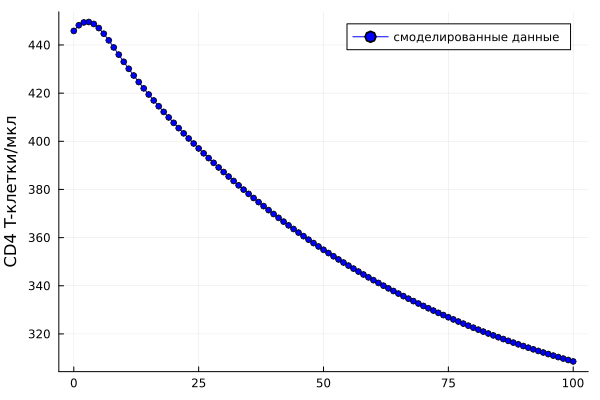

In [15]:
using Plots
plot(data.t,Total_CD4, ylabel = "CD4 T-клетки/мкл", label ="смоделированные данные", markershapes = :o, markersize = 3,c=:blue)


In [16]:
savefig("md_TTcell.png")

"c:\\Users\\Pavel\\YandexDisk\\3 семестр\\hiv\\hiv_mm_nn_opt\\md_TTcell.png"

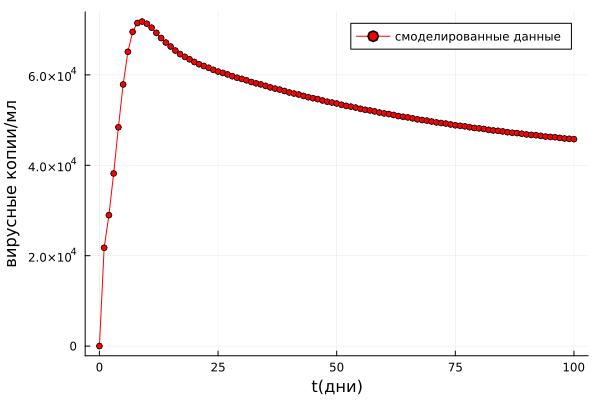

In [17]:
plot(data.t, VL,  xlabel = "t(дни)",c=:red,markershapes = :o, markersize = 3, ylabel = "вирусные копии/мл", label ="смоделированные данные")

In [18]:
savefig("md_VL.png")

"c:\\Users\\Pavel\\YandexDisk\\3 семестр\\hiv\\hiv_mm_nn_opt\\md_VL.png"

upload medical-experemental data for u_
- Virual Load data
- Total T-cells

In [ ]:
using DataFrames, CSV
name_Time = ["Pre-infection",
    "0 Weeks",
    "1 Weeks",
    "2 Weeks",
    "3 Weeks",
    "4 Weeks",
    "6 Months",
    "1 Year"]
    
val_Time =[0.0,
    7.0,
    14.0,
    21.0,
    28.0,
    35.0,
    180.0,
    365.0]
#P1
val_VL = [0.0, 5.89, 7.96,6.3,5.91,5.87,4.5,5.0]
val_CD4 = [1200.,890., 600.,420.,550.,520.,560.,580.]

meas_data = DataFrame(name=name_Time, day=val_Time, P1_VL=val_VL, P1_CD4=val_CD4)

loss_function for nn

In [38]:
len = 8
depvars = [:T_1,:Ts_1,:T_2,:Ts_2,:V_1,:V_2,:E_1,:E_2]
function additional_loss(phi, θ , p)
    return sum(sum(abs2, phi[i](t_ , θ[depvars[i]]) .- u_[[i], :])/len for i in 1:1:8)
end

additional_loss (generic function with 1 method)

layer

In [39]:
input_ = length(domains)
n = 8
chain1 = Lux.Chain(Dense(input_,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,1))
chain2 = Lux.Chain(Dense(input_,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,1))
chain3 = Lux.Chain(Dense(input_,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,1))

LoadError: UndefVarError: Lux not defined

In [ ]:
var = [T_1(t),Ts_1(t),T_2(t),Ts_2(t),V_1(t),V_2(t),E_1(t),E_2(t)]

discretization

In [ ]:
discretization = NeuralPDE.PhysicsInformedNN([chain1 , chain2, chain3],NeuralPDE.GridTraining(dt), param_estim=true, additional_loss=additional_loss)
@named pde_system = PDESystem(eqs,bcs,domains,[t],var,sp, defaults=Dict([p .=> 1.0 for p in sp]))
prob = NeuralPDE.discretize(pde_system,discretization)
callback = function (p,l)
    println("Current loss is: $l")
    return false
end

In [ ]:
res = Optimization.solve(prob, BFGS(); callback = callback, maxiters=5000)

In [ ]:
p_ = res.u[end-2:end]

approximate

In [ ]:
minimizers = [res.u.depvar[depvars[i]] for i in 1:8]
ts = [infimum(d.domain):dt/10:supremum(d.domain) for d in domains][1]
u_predict  = [[discretization.phi[i]([t],minimizers[i])[1] for t in ts] for i in 1:3]
plot(sol)
plot!(ts, u_predict, label = ["x(t)" "y(t)" "z(t)"])